In [66]:
# Instalando ibliotecas necessárias para as manipulaçãos

import numpy as np #p/ manipulação de matrizes
from skimage import io, data #manipulação e funções de manipulação de dados (dados foi usado apenas para teste)
import matplotlib.pyplot as plt #p/ demonstração de gráfico e das imagens
import os #acesso aos arquivos
import cv2 #manipulação do vídeo
import logging 

In [67]:
#formatando log para controle do fluxo
caminho = '../log/notebook.log'
logging.basicConfig(level=logging.INFO, filename=caminho, filemode='a', format="%(asctime)s - %(levelname)s - %(message)s", encoding='utf-8')

In [68]:
# Trecho para determinar a necessidade da equalização

def _desvio_padrao(frame_h:np.histogram)->tuple:
  media_ = np.mean(frame_h)
  logging.info("A média: %2.f", media_)
  dif_quadradas = (frame_h - media_) ** 2
  #logging.info("Matriz de diferenças quadradas: $s", str(dif_quadradas))
  media_diff_ = np.mean(dif_quadradas)
  logging.info("Media da Matriz de diferenças: %2.f", media_diff_)
  desvio_padrao = np.sqrt(media_diff_)
  return desvio_padrao, media_

def avalia_pic(matriz_imagem:np.array)->tuple:
    histograma = np.histogram(matriz_imagem, bins=256, range=(0,255))
    #plt.plot (histograma[0],'-k')
    desvio_, media_ = _desvio_padrao(histograma[0])
    logging.info("Desvio Padrão: %2.f", desvio_)
    coff = desvio_ / media_
    logging.info("Coeficiente de variação: %2.f", coff)
    if coff < 1.0: # a verificar
      y_n = False
    else: 
      y_n = True
    return y_n, histograma

In [69]:
# Funções para a equalização
def _funcao_transferencia(frame, frame_h:np.histogram):
  l,c = frame.shape
  logging.info("Dimensões do frame:", l, c)
  n = l*c 
  pr = frame_h[0]/ n
  return np.cumsum(pr)


def normalizacao_histogramica(histograma_:np.histogram, _transferencia, img:np.array):
  imgh = np.zeros_like(img).astype('float')
  l,c = img.shape
  for i in range(l):
    for j in range(c):
      imgh[i,j] = _transferencia[[img[i, j]]]
  return imgh

def demonstracao(img):
  _,ax = plt.subplots (1,2)
  ax[0].imshow ((img*255).astype('uint8'),cmap='gray',vmin=0,vmax=255)
  h = np.histogram (img,bins=256)
  ax[1].plot (h[0],'-k')
  logging.info("np.sum equalizado: %d", np.sum(h[0]))

In [70]:
def display_frames(frames, titles=None, cmap='gray'):
    num_frames = len(frames)
    num_cols = min(4, num_frames)  # Definir o número máximo de colunas como 4
    num_rows = (num_frames - 1) // num_cols + 1
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 4*num_rows))
    axes = axes.flatten()

    for i in range(num_frames):
        axes[i].imshow(frames[i], cmap=cmap)
        axes[i].axis('off')
        if titles:
            axes[i].set_title(titles[i])
    
    # Ocultar eixos extras
    for j in range(num_frames, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

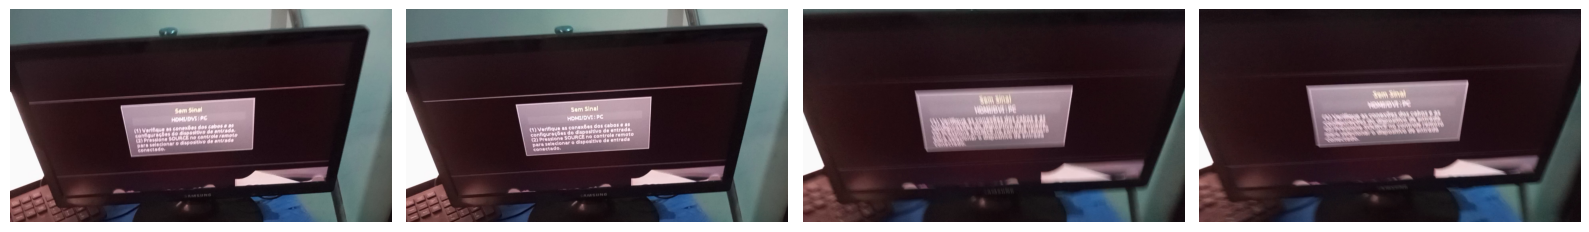

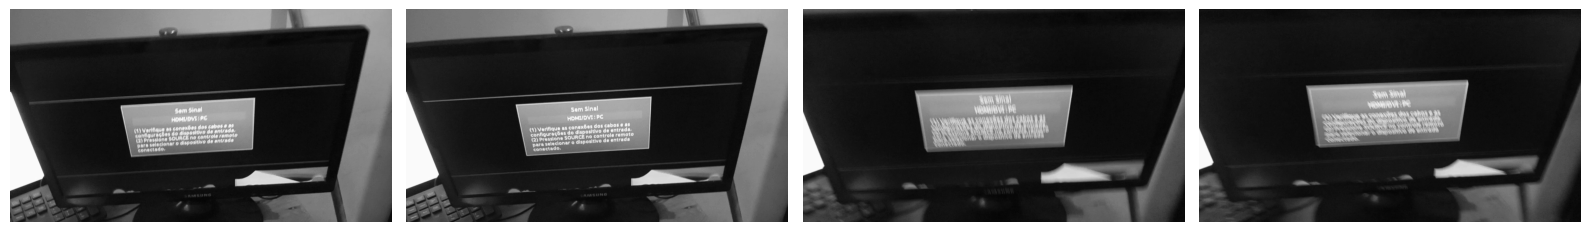

(1920, 3) (1920, 3)


In [72]:
#Capturar os videos
# Inicializar o objeto VideoCapture
caminho_video1 = '../tests/origem/VID_20240405_234240.mp4'
caminho_video2 = '../tests/origem/VID_20240405_234310.mp4'
caminho_video3 = '../tests/origem/VID-20240406-WA0059.mp4'

cap = cv2.VideoCapture(caminho_video3)

frames = []
frames_gray = []
frames_equalized = []

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        logging.error("Can't receive frame (stream end?). Exiting ...")
        break
    frames.append(frame)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frames_gray.append(gray)
    yeah, h_ = avalia_pic(gray)
    
    ##############
    video_writer = cv2.VideoWriter(
    "../tests/saida/video.avi",
    cv2.VideoWriter_fourcc(*'mp4v'),
    30,
    (frame.shape[1], frame.shape[0]),  
    )

    ##############
    if yeah:
        func = _funcao_transferencia(gray, h_)
        imgh = normalizacao_histogramica(h_, func, gray)
        video_writer.write(imgh.astype(np.uint8))
    else:
        video_writer.write(gray)
    video_writer.release()

intervalo = frames[0:2] + frames[10:12]
display_frames(intervalo)
intervalo2 = frames_gray[0:2] + frames_gray[10:12]
display_frames(intervalo2)
l, c = frames[0][0].shape, frames[0][1].shape
print(l, c)

#video_writer.release()
cap.release()